## 1.3 Import Drivers+, Download Overlay <a class="anchor" id="import"></a>

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout)
logging.getLogger('mkidgen3').setLevel('DEBUG')
import pynq
import time
from pynq import PL

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
import mkidgen3.fccm22_demo
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.testutils import *

In [29]:
# Download Overlay, Optionally Configure Clocks
ol = g3.configure('cordic_16_15_fir_22_0.bit', clocks=True, external_10mhz=True, ignore_version=True)

INFO:mkidgen3:PL Bitfile: /home/xilinx/jupyter_notebooks/gen3top_benchmark_0831/cordic_16_15_fir_22_0.bit (2022/9/9 0:14:40 +766188)  Loaded: True


### Generate and Play DAC Waveform

In [30]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([200e6+107e3, 300.5e6-33e3, 400e6+20e3]) 
amplitudes = np.ones_like(tones)/tones.shape[0]

In [31]:
g3.set_waveform(tones,amplitudes,fpgen='simple')

DEBUG:mkidgen3:Comb shape: (524288,). 
Total Samples: 524288. Memory: 2 MB



{'iq': array([-0.05628271+0.3259947j , -0.19641575+0.2688639j ,
        -0.28309622+0.1481414j , ...,  0.21937458+0.07879328j,
         0.19231784+0.20388965j,  0.08989485+0.29993388j], dtype=complex64),
 'frequencies': array([2.00109375e+08, 3.00468750e+08, 4.00023438e+08]),
 'phases': array([1.88386861, 4.97212267, 1.68875799])}

### Capture & Plot DAC Output Using RFSoC ADCs

With the ZCU111 connected in loopback, we can sample the DAC output with the RFSoC ADCs and capture the result to the PL DRAM where we can visualize it in this notebook.

In [32]:
N = 2**19 # Number of samples to capture (full waveform)
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)

In [33]:
# Trigger Capture
ol.capture.capture_adc(N, complex=True) # throw away capture to clear any startup garbage
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V

DEBUG:mkidgen3.drivers.capture:Found 2 iq capture taps
DEBUG:mkidgen3.drivers.capture:Found 2 phase capture taps
DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500000000 from source adc
DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500200000 from source adc


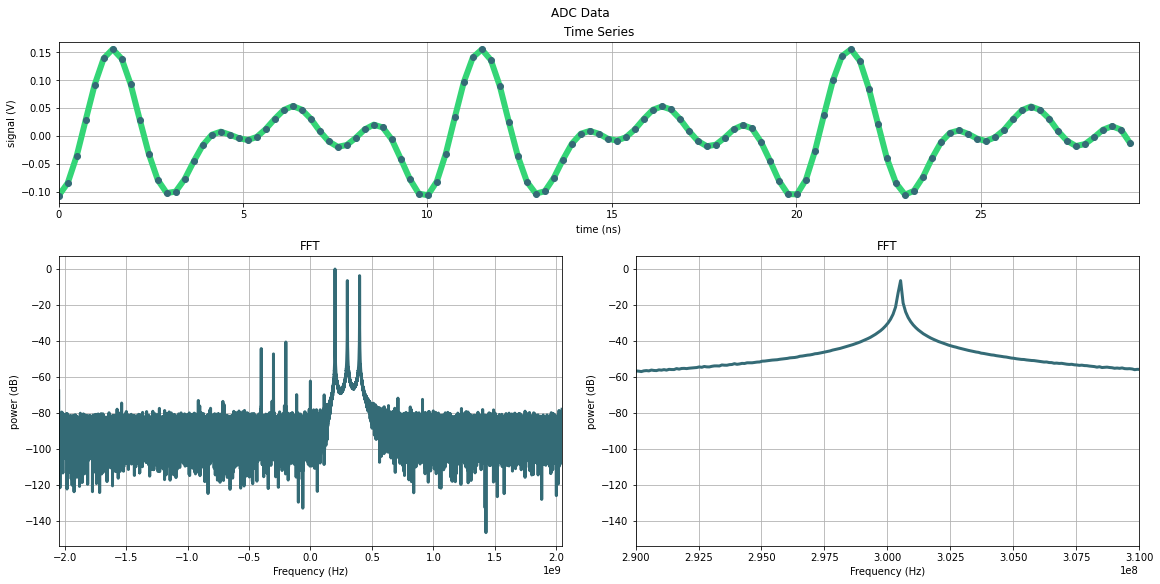

In [34]:
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (2.9e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

As you may have discovered the QMC is very sensitive. It's hard to do better than 40 dB-- almost any noticable change will make it much worse!

## 2.2 Oversampled Polyphase Filter Bank (OPFB) <a class="anchor" id="opfb"></a>

The OPFB is a 4,096-channel, 2/1 oversampled 4 GHz channelizer. It takes in 2, 4.096 GSPS data streams--one from and I ADC and the other from a Q ADC, and produces 4096 2 MHz channels which overlap by 50%. This overlapping feature insures that no matter where a signal exists in-band, it will be able to pass through the channelizer un-attenuated. This IP is the subject of [this publication](https://ieeexplore.ieee.org/document/9336352) and is also documented in a [stand-alone git repo](https://github.com/MazinLab/RFSoC_OPFB).

After being sampled by the ADCs, we can run the data through the OPFB IP and capture the result to the PPL DDR4 for visualization.

### OPFB Capture

<script src="https://cdnjs.cloudflare.com/ajax/libs/wavedrom/2.6.8/skins/default.js" type="text/javascript"></script>
<body onload="WaveDrom.ProcessAll()">
<script type="WaveDrom">
{ signal : [
  { name: "clk",  wave: "p......" },
  { name: "bus",  wave: "x.34.5x",   data: "head body tail" },
  { name: "wire", wave: "0.1..0." },
]}
</script>

In [35]:
# Capture N samples from all 4096 OPFB Bins
opfb_raw = g3.capture_opfb(1024, raw=True)
# Convert to complex numbers
opfb_fp = opfb_raw[..., 0] + 1j*(opfb_raw[..., 1])

DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x500400000 from source rawiq
DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x500c00000 from source rawiq


### Plot OPFB

We expect our 300 MHz tone to be in bin 2348. Because the channelizer is 50% overlapping, we also expect to see the 300.5 MHz tone in that bin as well as the neighboring bin with equal magnitude in each bin. Indeed we see that is the case below.

/home/xilinx/src/mkidgen3/mkidgen3/dsp.py:27: RuntimeWarning: divide by zero encountered in log10
  x = 20 * np.log10(np.abs(np.fft.fft(data, axis=0)))


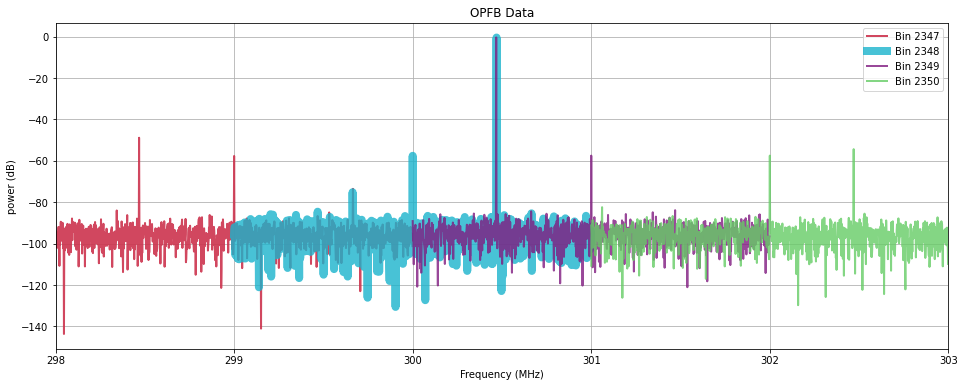

In [36]:
mkidgen3.fccm22_demo.plot_fccm_demo_bins(opfb_fp)

## 2.5 DDC  <a class="anchor" id="DDC"></a>

Lets look a bit more closely at the data out of those bins before and after digitally downconverting it.

### Post-Channelization IQ Data
Now let's capture IQ data before the DDC and see if we can recover these same phases after the DDC

## Assign Resonator Channels

In [37]:
ol.photon_pipe.reschan.resonator_ddc=ol.photon_pipe.reschan.resonator_ddc_control

In [38]:
bins = np.zeros(2048, dtype=int)
bins[:tones.size] = g3.opfb_bin_number(tones,ssr_raw_order=True)
ol.photon_pipe.reschan.bin_to_res.bins = bins

In [39]:
ddc_tones = np.zeros(2048)
ddc_tones[:tones.size]=tones
g3.configure_ddc(ddc_tones, quantize=True)  #phase goes from [-pi, pi), like tones.size

DEBUG:mkidgen3:Writing DDC tones...
DEBUG:mkidgen3:DDC tones written.


In [40]:
tones_khz=g3.drivers.ddc.tone_increments(tones, quantize=True)*1e3
bin_centers = g3.opfb_bin_center(g3.opfb_bin_number(tones, ssr_raw_order=True), ssr_order=True)

DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x501400000 from source rawiq
DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x501c00000 from source iq
901 901


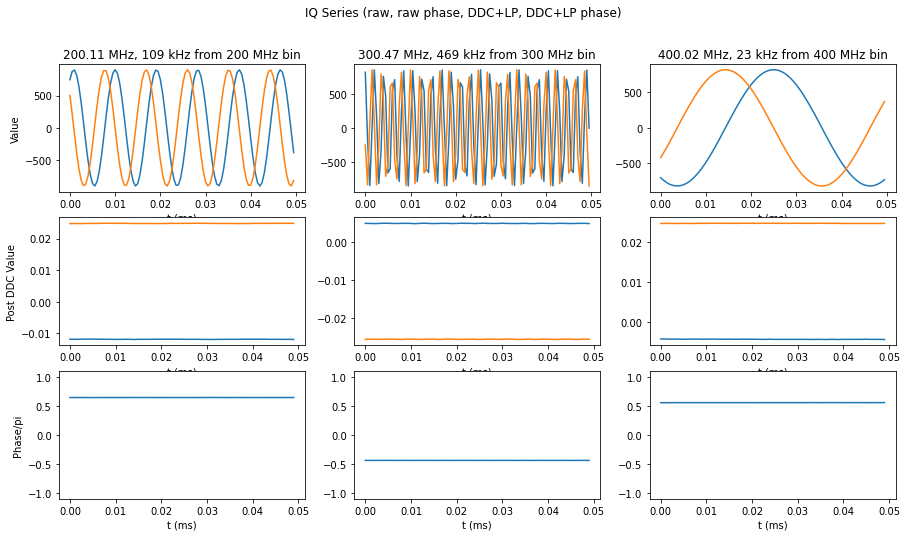

In [41]:
riq,iq=ol.capture.ddc_compare_cap()
fig, axes = plt.subplots(3,3, figsize=(15,8))
for i, ax in enumerate(axes.T):
    plot_waveforms(riq[:100, i], 2e6, ax=ax[0], label='Value' if not i else '')
    plt.title(f'{tones[i]/1e6:.2f} MHz, {tones_khz[i]:.0f} kHz from {bin_centers[i]/1e6:.0f} MHz bin')
    plot_waveforms(iq[:50, i]/2**15, 1e6, ax=ax[1], label='Post DDC Value' if not i else '')
    plot_waveforms(iq[:50, i], 1e6, sw_phase=True, ax=ax[2], label='Phase/pi' if not i else '')
plt.suptitle('IQ Series (raw, raw phase, DDC+LP, DDC+LP phase)');

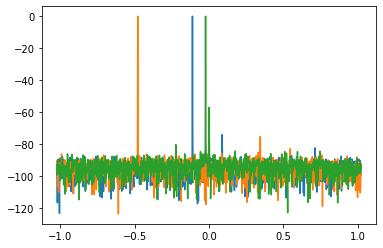

In [42]:
plot_res_chan(riq,0)
plot_res_chan(riq,1)
plot_res_chan(riq,2)

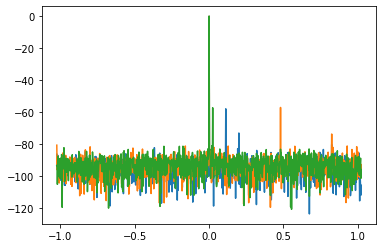

In [43]:
plot_res_chan(iq,0)
plot_res_chan(iq,1)
plot_res_chan(iq,2)

## Convert to Phase

DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x502400000 from source iq
DEBUG:mkidgen3.drivers.capture:Capturing ~4.00 MB of data @ 4096.0 MBps. ETA 1 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 4194304 bytes (65536 beats) to address 0x502c00000 from source rawphase


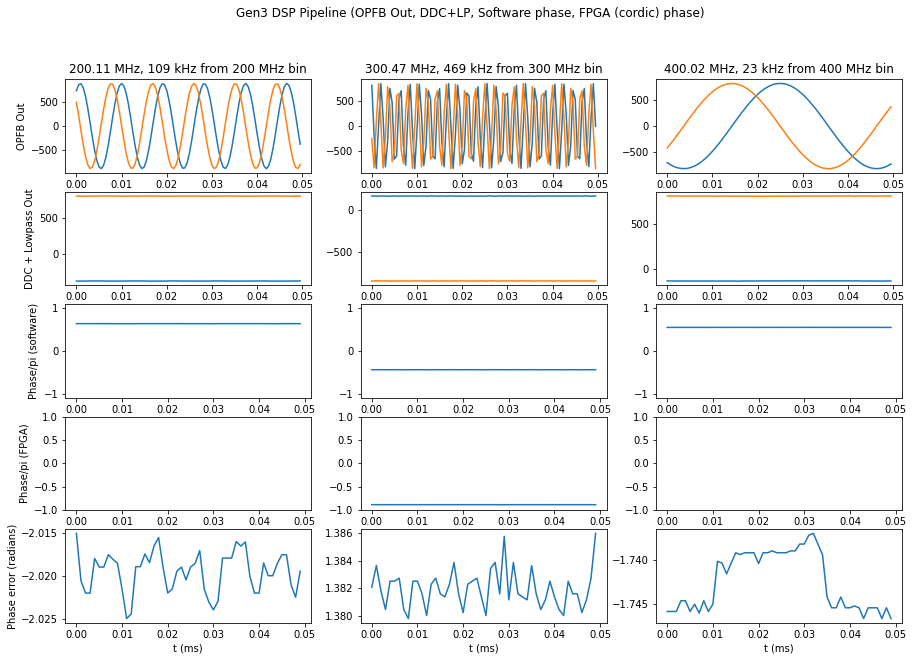

In [44]:
iq, phase = ol.capture.cap_cordic_compare()
tonesplt = tones
chan_plt=[0,1,2]
bin_centers = g3.opfb_bin_center(g3.opfb_bin_number(tonesplt, ssr_raw_order=True), ssr_order=True)
fig, axes = plt.subplots(5,3, figsize=(15,10))
tones_khz=g3.drivers.ddc.tone_increments(tonesplt, quantize=True)*1e3
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plot_waveforms(riq[:100, i], 2e6, ax=ax[0], label='OPFB Out' if not j else '')
    plt.title(f'{tonesplt[j]/1e6:.2f} MHz, {tones_khz[j]:.0f} kHz from {bin_centers[j]/1e6:.0f} MHz bin')
    plot_waveforms(iq[:100, i], 2e6, sw_phase=False, ax=ax[1], label='DDC + Lowpass Out' if not j else '')
    plot_waveforms(iq[:50, i], 1e6, sw_phase = True, ax=ax[2], label='Phase/pi (software)' if not j else '')
    plot_waveforms(phase[:50, i]/2**15, 1e6, cordic=True, ax=ax[3], label='Phase/pi (FPGA)' if not j else '')
    plt.ylim([-1,1])
    err=np.angle(iq[:50, i])-np.pi*phase[:50, i]/2**15
    plot_waveforms(err, 1e6, cordic=True, ax=ax[4], label='Phase error (radians)' if not j else '')
    #plt.ylim([-1,1])
plt.suptitle('Gen3 DSP Pipeline (OPFB Out, DDC+LP, Software phase, FPGA (cordic) phase)');

## Optimal Filter

In [45]:
unity=np.zeros(30, dtype=np.int16)
unity[0] = 2**15-1

In [46]:
## RAW
phases={}
n_points=1024
x = ol.capture.capture_phase(n_points, 'all', tap_location='rawphase')
phases['raw']=np.array(x)
x.freebuffer()

## LOAD UNITY FILTER EVERY CHANNEL
ol.photon_pipe.phasematch.load_coeff(0,unity, vet=False, raw=True)
ol.photon_pipe.phasematch.load_coeff(1,unity, vet=False, raw=True)
ol.photon_pipe.phasematch.load_coeff(2,unity, vet=False, raw=True, force_commit=True)
time.sleep(1)
# Capture
x = ol.capture.capture_phase(n_points, 'all', tap_location='phase')
phases['unity']=np.array(x)
x.freebuffer()

DEBUG:mkidgen3.drivers.capture:Capturing ~4.00 MB of data @ 4096.0 MBps. ETA 1 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 4194304 bytes (65536 beats) to address 0x503000000 from source rawphase
DEBUG:mkidgen3.drivers.axififo:ISR at TX start: Register(RFPE=0, RFPF=0, TFPE=1, TFPF=1, RRC=0, TRC=0, TSE=0, RC=0, TC=0, TPOE=0, RPUE=0, RPORE=0, RPURE=0)
DEBUG:mkidgen3.drivers.axififo:ISR at TX end: Register(RFPE=0, RFPF=0, TFPE=1, TFPF=0, RRC=0, TRC=0, TSE=0, RC=0, TC=1, TPOE=0, RPUE=0, RPORE=0, RPURE=0)
DEBUG:mkidgen3.drivers.axififo:ISR at TX start: Register(RFPE=0, RFPF=0, TFPE=1, TFPF=0, RRC=0, TRC=0, TSE=0, RC=0, TC=1, TPOE=0, RPUE=0, RPORE=0, RPURE=0)
DEBUG:mkidgen3.drivers.axififo:ISR at TX end: Register(RFPE=0, RFPF=0, TFPE=1, TFPF=0, RRC=0, TRC=0, TSE=0, RC=0, TC=1, TPOE=0, RPUE=0, RPORE=0, RPURE=0)
DEBUG:mkidgen3.drivers.axififo:ISR at TX start: Register(RFPE=0, RFPF=0, TFPE=1, TFPF=0, RRC=0, TRC=0, TSE=0, RC=0, TC=1, TPOE=0, RPUE=0, RPORE=0, RPURE=0)
DEBUG:mkidgen3.driv

/home/xilinx/src/mkidgen3/mkidgen3/drivers/axififo.py:43: RuntimeWarning: coroutine 'Interrupt.wait' was never awaited
  self.interrupt.wait()  # wait for the transmit to complete


DEBUG:mkidgen3.drivers.capture:Capturing ~4.00 MB of data @ 4096.0 MBps. ETA 1 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 4194304 bytes (65536 beats) to address 0x503400000 from source phase


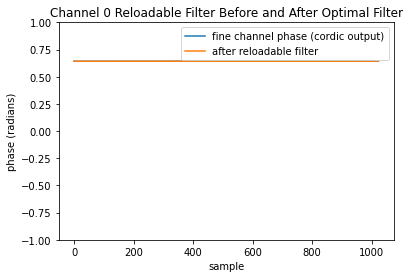

In [56]:
plt.plot(phases['raw'][:,0]/(2**15-1))
plt.plot((phases['unity'][::,0])/(2**15-1))
plt.ylim([-1,1]);
plt.xlabel('sample')
plt.ylabel('phase (radians)')
plt.legend(['fine channel phase (cordic output)', 'after reloadable filter'])
plt.title('Channel 0 Reloadable Filter Before and After Optimal Filter');

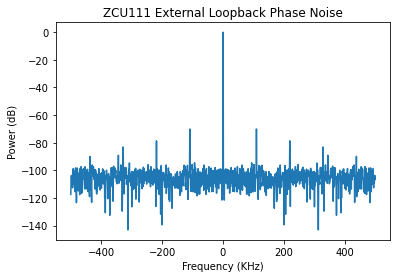

In [55]:
phase_fft = 20*np.log10(np.fft.fftshift(np.abs(np.fft.fft(phases['raw'][:,0]))))
phase_fft = phase_fft - max(phase_fft)
plt.plot(np.linspace(-0.5e3,0.5e3,phase_fft.size),phase_fft)
plt.xlabel('Frequency (KHz)')
plt.ylabel('Power (dB)')
plt.title('ZCU111 External Loopback Phase Noise');